<a href="https://colab.research.google.com/github/Markfryazino/stanford_sentiment/blob/master/research/lstm_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2020-07-03 10:09:43--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  41.5MB/s    in 1.9s    

2020-07-03 10:09:45 (41.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import numpy as np
import pandas as pd

PATH = './'

import os
train_pos_names = os.listdir(PATH + 'aclImdb/train/pos')
train_neg_names = os.listdir(PATH + 'aclImdb/train/neg')
test_pos_names = os.listdir(PATH + 'aclImdb/test/pos')
test_neg_names = os.listdir(PATH + 'aclImdb/test/neg')

In [ ]:
y_train = [int(s.split('_')[1].split('.')[0]) for s in train_pos_names] + \
          [int(s.split('_')[1].split('.')[0]) for s in train_neg_names]
    
y_test = [int(s.split('_')[1].split('.')[0]) for s in test_pos_names] + \
          [int(s.split('_')[1].split('.')[0]) for s in test_neg_names]

In [ ]:
train = []
test = []

for name in train_pos_names:
    with open(PATH + 'aclImdb/train/pos/' + name) as f:
        train.append(f.read())
        
for name in train_neg_names:
    with open(PATH + 'aclImdb/train/neg/' + name) as f:
        train.append(f.read())
        
for name in test_pos_names:
    with open(PATH + 'aclImdb/test/pos/' + name) as f:
        test.append(f.read())
        
for name in test_neg_names:
    with open(PATH + 'aclImdb/test/neg/' + name) as f:
        test.append(f.read())

In [ ]:
from sklearn.model_selection import train_test_split

train, val, y_train, y_val = train_test_split(train, y_train, shuffle=True, test_size=0.2)

In [ ]:
import re
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

class Tokenizer:
    def __init__(self, data=None, maxlen=1024, mincount=3, params=None):
        if params is not None:
            self.maxlen = params['maxlen']
            self.mincount = params['mincount']
            self.w2i = params['w2i']
            self.i2w = params['i2w']
            self.num_tokens = len(self.w2i)
        else:
            self.maxlen = maxlen
            self.mincount = mincount
            text = ' '.join(data).lower()
            text = re.sub(r'[^\w\s]','',text)
            words = dict(Counter((text.split())))
            words = {key for key, val in words.items() if val >= mincount}
            self.num_tokens = len(words) + 4
            self.w2i = {'<unk>': 0, '<BOS>': 1, '<EOS>': 2, '<pad>': 3}
            self.i2w = ['<unk', '<BOS>', '<EOS>', '<pad>']
            for w in words:
                 self.w2i[w] = len(self.i2w)
                 self.i2w.append(w)
    
    def tokenize(self, data):
        output = []
        for sent in data:
            text = re.sub(r'[^\w\s]','',sent.lower())
            output.append([1])
            for w in text.split():
                if w in self.w2i:
                    output[-1].append(self.w2i[w])
                else:
                    output[-1].append(0)
            output[-1].append(2)
        return pad_sequences(output, maxlen=self.maxlen, value=3)
    
    def save(self, path):
        params = {'w2i': self.w2i, 'i2w': self.i2w, 'maxlen': self.maxlen, 'mincount': self.mincount}
        with open(path, 'w') as file:
          file.write(str(params))

    @staticmethod
    def load(path):
        with open(path) as file:
          d = eval(file.read())
          return Tokenizer(params=d)


In [ ]:
tok = Tokenizer(train, maxlen=512, mincount=3)

In [ ]:
train_tok = tok.tokenize(train)
val_tok = tok.tokenize(val)
test_tok = tok.tokenize(test)

tok.save('models/tokenizer.tok')

In [ ]:
import torch
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self, num_tokens, emb_size=16, hid_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.dropout = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hid_size, 1)
        
    def forward(self, x):
        x = x.type(torch.LongTensor).to(device)
        emb = self.dropout(self.emb(x))
        h, _ = self.lstm(emb)
        estimate = self.fc(h[:, -1, :])
        return torch.flatten(estimate)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]

In [ ]:
train_dset = TextDataset(train_tok, y_train)
val_dset = TextDataset(val_tok, y_val)
test_dset = TextDataset(test_tok, y_test)

In [ ]:
train_loader = DataLoader(train_dset, batch_size=16)
val_loader = DataLoader(val_dset, batch_size=16)
test_loader = DataLoader(test_dset, batch_size=16)

device = torch.device("cuda:0")

In [ ]:
def compute_quality(model, loader, classification=False):
    model.eval()
    
    loss_acum = 0.
    correct = total = correct_class = 0
    
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.type(torch.FloatTensor).to(device)

            pred = model(x_gpu)

            if classification:
                y_gpu = (y > 5).type(torch.FloatTensor).to(device)
            else:
                y_add = (y > 5).type(torch.IntTensor).to(device)
                pred_class = (pred > 5).type(torch.IntTensor).to(device)
                correct_class += torch.sum((pred_class == y_add))

            loss_val = loss(pred, y_gpu)
            loss_acum += loss_val
            
            pred_rounded = torch.round(pred)
            correct += torch.sum(pred_rounded == y_gpu)
            total += y.shape[0]
            del x_gpu, y_gpu
        
    return loss_acum / (i_step + 1), float(correct) / total, float(correct_class) / total

def train_model(model, train_loader, val_loader, epochs, optimizer, loss, plato_scheduler=None, 
                scheduler=None, classification=False):
    loss_history = []
    acc_history = []
    bacc_history = []
    
    for epoch in range(epochs):
        model.train()
        
        loss_acum = 0.
        correct = total = correct_class = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.type(torch.FloatTensor).to(device)

            pred = model(x_gpu)

            if classification:
                y_gpu = (y > 5).type(torch.FloatTensor).to(device)
            else:
                y_add = (y > 5).type(torch.IntTensor).to(device)
                pred_class = (pred > 5).type(torch.IntTensor).to(device)
                correct_class += torch.sum((pred_class == y_add))


            loss_val = loss(pred, y_gpu)
            loss_acum += loss_val
            
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            pred_rounded = torch.round(pred)
            correct += torch.sum(pred_rounded == y_gpu)
            total += y.shape[0]
            del x_gpu, y_gpu
            
        train_acc = float(correct) / total
        if not classification:
          train_bacc = float(correct_class) / total
        train_loss = loss_acum / (i_step + 1)
        
        val_loss, val_acc, val_bacc = compute_quality(model, val_loader, classification=classification)
        loss_history.append(val_loss)
        acc_history.append(val_acc)
        if not classification:
            bacc_history.append(val_bacc)

        if plato_scheduler != None:
            scheduler.step(val_acc)
        if scheduler != None:
            scheduler.step()
        
        if classification:
            print(f'Epoch {epoch}\nTrain loss: {train_loss}\nTrain accuracy: {train_acc}')
            print(f'Val loss: {val_loss}\nVal accuracy: {val_acc}')
        else:
            print(f'Epoch {epoch}\nTrain loss: {train_loss}\nTrain accuracy: {train_acc}\nTrain binary accuracy: {train_bacc}')
            print(f'Val loss: {val_loss}\nVal accuracy: {val_acc}\nVal binary accuracy: {val_bacc}')
    return loss_history, acc_history, bacc_history

In [ ]:
model = nn.Sequential(
    SimpleModel(tok.num_tokens, 16, 32),
    nn.Sigmoid()
)

model.to(device)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max')
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.1)

loss_hist, acc_hist, _ = train_model(model, train_loader, val_loader, 15, optimizer, loss, 
                                   classification=True, plato_scheduler=scheduler1, scheduler=scheduler2)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train loss: 0.6854073405265808
Train accuracy: 0.54095
Val loss: 0.6714863181114197
Val accuracy: 0.576
Epoch 1
Train loss: 0.6433324217796326
Train accuracy: 0.6291
Val loss: 0.5599139332771301
Val accuracy: 0.7224
Epoch 2
Train loss: 0.5978174805641174
Train accuracy: 0.6841
Val loss: 0.7094461917877197
Val accuracy: 0.605
Epoch 3
Train loss: 0.5873492956161499
Train accuracy: 0.68585
Val loss: 0.5772808790206909
Val accuracy: 0.7316
Epoch 4
Train loss: 0.5184518694877625
Train accuracy: 0.7459
Val loss: 0.48493483662605286
Val accuracy: 0.7796
Epoch 5
Train loss: 0.49291589856147766
Train accuracy: 0.7665
Val loss: 0.4853805601596832
Val accuracy: 0.7912
Epoch 6
Train loss: 0.44871288537979126
Train accuracy: 0.79705
Val loss: 0.5286132097244263
Val accuracy: 0.788
Epoch 7
Train loss: 0.4285208284854889
Train accuracy: 0.8104
Val loss: 0.4969332814216614
Val accuracy: 0.7792
Epoch 8
Train loss: 0.4101405739784241
Train accuracy: 0.8217
Val loss: 0.4746580719947815
Val accura

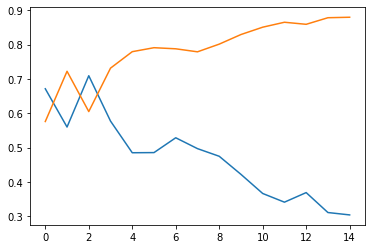

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(15), loss_hist)
plt.plot(range(15), acc_hist)

In [ ]:
torch.save(model.state_dict(), PATH + 'models/classification.pt')

In [ ]:
model = nn.Sequential(
    SimpleModel(tok.num_tokens, 16, 32),
    nn.Sigmoid()
)

model.load_state_dict(torch.load('models/classification.pt'))

<All keys matched successfully>

In [ ]:
reg_model = model[0].to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max')
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.1)

val_loss, val_acc, val_bacc = train_model(reg_model, train_loader, val_loader, 10, 
                                          optimizer, loss, scheduler=scheduler2, plato_scheduler=scheduler1)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train loss: 4.710617542266846
Train accuracy: 0.1838
Train binary accuracy: 0.8838
Val loss: 5.3728861808776855
Val accuracy: 0.1668
Val binary accuracy: 0.85
Epoch 1
Train loss: 3.688176155090332
Train accuracy: 0.1897
Train binary accuracy: 0.90475
Val loss: 5.049951553344727
Val accuracy: 0.1652
Val binary accuracy: 0.8574
Epoch 2
Train loss: 3.3721394538879395
Train accuracy: 0.197
Train binary accuracy: 0.91485
Val loss: 5.178640365600586
Val accuracy: 0.1666
Val binary accuracy: 0.8514
Epoch 3
Train loss: 3.2461373805999756
Train accuracy: 0.19985
Train binary accuracy: 0.9178
Val loss: 4.9475836753845215
Val accuracy: 0.1784
Val binary accuracy: 0.851
Epoch 4
Train loss: 3.162492036819458
Train accuracy: 0.2044
Train binary accuracy: 0.9206
Val loss: 4.871768951416016
Val accuracy: 0.1942
Val binary accuracy: 0.866
Epoch 5
Train loss: 2.9633326530456543
Train accuracy: 0.2123
Train binary accuracy: 0.92475
Val loss: 4.485567569732666
Val accuracy: 0.2066
Val binary accur

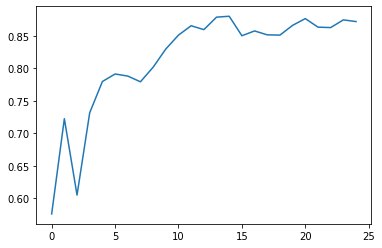

In [ ]:
plt.plot(acc_hist + val_bacc)

In [ ]:
torch.save(reg_model.state_dict(), 'models/regression.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
loss_val, acc, bacc = compute_quality(reg_model, test_loader, False)

In [ ]:
print(loss_val, acc, bacc)

tensor(4.7000, device='cuda:0') 0.21756 0.86096


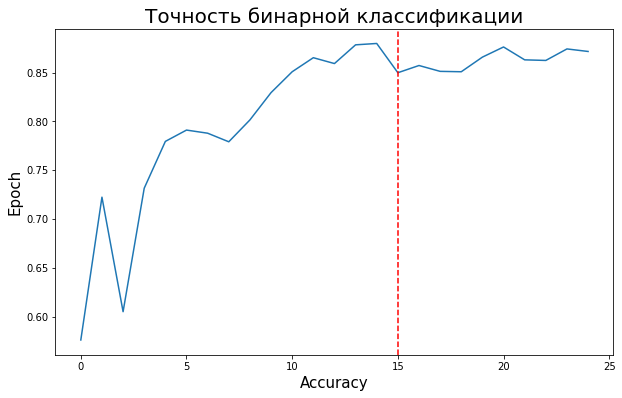

In [ ]:
bacc = acc_hist + val_bacc

import seaborn as sns

plt.figure(figsize=(10, 6))
plt.title('Точность бинарной классификации', {'fontsize': 20})
plt.xlabel('Accuracy', fontsize=15)
plt.ylabel('Epoch', fontsize=15)
ax = sns.lineplot(range(25), bacc)

ax.axvline(x=15, color='red', linestyle='--');

In [ ]:
oh = []
for x, y in test_loader:
    oh.append((y, reg_model(x)))

In [ ]:
oh[802]

(tensor([1, 2, 1, 1, 4, 2, 1, 1, 1, 4, 1, 4, 3, 3, 1, 1]),
 tensor([1.5417, 1.6641, 1.1093, 3.2495, 1.4943, 7.2473, 5.3790, 1.4320, 1.8551,
         2.8277, 2.2517, 2.4079, 1.7589, 2.0598, 1.4981, 1.3138],
        device='cuda:0', grad_fn=<ViewBackward>))